In [1]:
import numpy as np, matplotlib.pyplot as plt

import torch, torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import mlflow

# This emsures that our results are predictable
torch.manual_seed(0)
np.random.seed(0)

# MLflow set-up
* mlflow.set_tracking_uri : sets storage location for files (on your device or in the cloud) - this should be the argument of mlflow ui --backend-store-uri command
* mlflow.set_experiment : sets the experiment name (you can also set it by experiment id)
* mlflow.pytorch.autolog : enables/disables autologging for PyTorch

In [2]:
mlflow.set_tracking_uri('./mlflow_uri/')
mlflow.set_experiment("fashion_mnist")
mlflow.pytorch.autolog(disable=True)

# Fashion MNIST
Here we train the AI model on the Fashion MNIST dataset

## Hyperparameters

In [3]:
# Hyperparameters
mini_batch_size = 256
n_epochs = 1 # Since our batch size is relatively small, adding more epochs will not help very much with accuracy

class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
# Targets in the dataset are represented by integers 0 - 9 corresponding to these classes

## Loading Data and Preprocessing

In [4]:
# Loading the Fashion MNIST dataset
transform = transforms.Compose([
             transforms.Resize((28,28)),
             transforms.ToTensor(),
             transforms.Grayscale(),
             transforms.Normalize((0,), (1,))
]) # Does normalization of data for us and ensures the data is in the correct shape and data type

train_set = datasets.FashionMNIST('.', train=True, download=True, transform=transform)
test_set = datasets.FashionMNIST('.', train=False, download=True, transform=transform) 
# The data is downloaded only the 1st time
    
train_load = DataLoader(train_set, batch_size=mini_batch_size, shuffle=True)
test_load = DataLoader(test_set, batch_size=mini_batch_size, shuffle=True)
# Dataloaders split the data into mini batches. Here size is 128

## Plotting random images

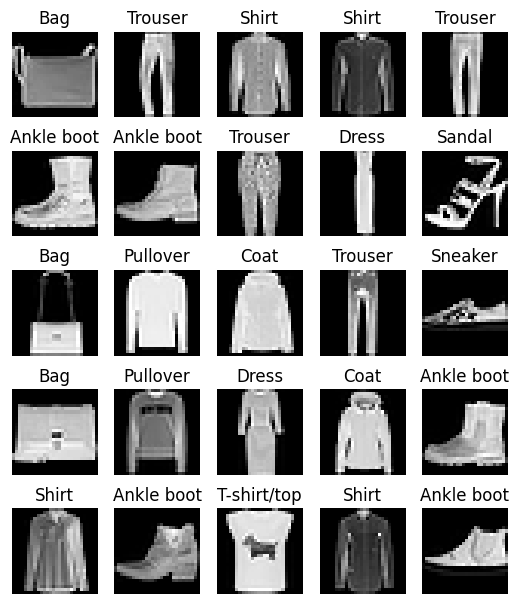

In [7]:
train_images, train_labels = zip(*datasets.FashionMNIST('.', train=True, download=True, transform=transform))
# This is faster than using zip(*train_set)
train_images = np.asarray([np.array(img) for img in train_images], dtype=np.float32)
train_labels = np.asarray(train_labels, dtype=np.int64)
# A way to get your data in the form a numpy array

#Plotting random images from the data with matplotlib
img_indices = np.array([np.random.randint(0, len(train_images)) for i in range(25)]) # An array of random integers
fig, axes = plt.subplots(5, 5)
# A plot with 5 subplots
for n, i in enumerate(img_indices):
    axes[n//5, n%5].set_title(class_names[train_labels[i]])
    # // is integer division. This gets us the data in rows and columns of the graph
    img = train_images[i] 
    axes[n//5, n%5].axis('off') # No need for z and y axes
    axes[n//5, n%5].imshow(img.squeeze(), cmap='gray') # Syntax for plotting images in numpy
plt.subplots_adjust(bottom=0, top=1.2) # Resizing

## Model Architecture
We define a CNN and an ANN model here. The CNN performs better as FashionMNIST is an image dataset.

In [6]:
class CNN(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.convolutions = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            # 1 input image. If we had an RGB image, it would be Conv2d(3, 32, 3, padding=1)
            # 32 output images, i.e, 32 kernels and 32 output images are produced
            nn.ReLU(),
            # The activation function
            nn.MaxPool2d(2),
            # Pooling with 2 x 2 blocks
            nn.Conv2d(32, 64, 3, padding=1),
            # Now we have those 32 images and we make 64 from them
            nn.ReLU(),
            nn.MaxPool2d(2)
            # Pooling again
        )
        self.fully_connected = nn.Sequential(
            nn.Flatten(),
            nn.Linear((28*28*64)//16, 600),
            # The image shape was initially 28 x 28, by pooling we've made it 7 x 7, so we divide by 16
            # We multiply by 64 because the model has learnt 64 features.
            nn.Linear(600, 128),
            nn.Linear(128, 10)
            # We have 10 output neurons (1 for each class)
        )
    
    def forward(self, inputs):
        x = self.convolutions(inputs)
        # Functions in convolution layers are run
        x = self.fully_connected(x)
        # Functions in fully connected layer are run
        return x
    @torch.inference_mode
    def predict(self, inputs):
        # This function is used for prediction
        x = self.convolutions(inputs)
        x = self.fully_connected(x)
        return x.max(1)[1]

class ANN(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 600),
            nn.ReLU(),
            nn.Linear(600, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.ReLU()
        )
        # This is an ordinary neural network for comparison

    def forward(self, inputs):
        x = self.stack(inputs)
        return x

cnn_model = CNN()
ann_model = ANN()

cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=2e-3)
ann_optimizer = torch.optim.Adam(ann_model.parameters(), lr=2e-3)
# Adam is being used as optimizer
loss_fn = nn.CrossEntropyLoss()
# Cross entropy is used for loss function

## Training Function

In [7]:
# Defining one epoch of training
def train(model, train_loader=train_load, optimizer=cnn_optimizer, loss=loss_fn, ps=50):
    # We train the appropriate model with the input data and the appropriate optimizer
    # ps is how often we print the accuracy
    train_iter = iter(train_load)
    model.train()
    # Puts model in train mode
    for i, (data, targets) in enumerate(train_iter):
        # i is iteration, data = 1 mini batch of images, targets = 1 mini batch target values
        # This repeats for all mini batches 
        outputs = model.forward(data) # Forward pass
        loss_val = loss(outputs, targets) # Loss computation
        optimizer.zero_grad()  # Ensures gradients stored in optimizer are reset before each backward pass
        loss_val.backward() # Backward pass
        optimizer.step() # Backward pass

        if ps and i % ps == 0:
            model.eval()
            # Puts model in evaluation mode, so we 
            with torch.no_grad():
                print(f"Loss is {loss_val}")
                predicted = outputs.max(1)[1]
                correct = (predicted == targets).sum().item()
                accuracy = correct/len(targets)
                print(f"Train accuracy is {accuracy*100:.3f}%")
                

## Accuracy Function

In [12]:
def accuracy(model, test):
    # Evaluate a model given a test loader
    model.eval()
    with torch.no_grad():
        count = 0
        correct = 0
        for data, targets in iter(test):
            outputs = model.forward(data)
            predicted = outputs.max(1)[1] # Maximum output is predicted class
            count += len(targets) # Total length of datasetS
            correct += (predicted == targets).sum().item()
            # This gives a tensor of True and False values and adds no. of True values to correct each iteration
        accuracy = correct/count
        return accuracy

In [2]:
''' tensor([ True,  True,  True,  True,  True,  True, False,  True, False,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True, False,  True,  True,  True, False,  True, False,  True,  True,
         True,  True,  True, False,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True, False,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True, False,
         True,  True,  True,  True,  True,  True, False, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True, False,  True, False,  True,  True]) '''
# Ouptut of predicted == targets from accuracy function - this is typecast to 1s and 0s when .sum() is used


# Back to MLflow - Running the models with mlflow

In [9]:
params_cnn = {
    'batch_size': mini_batch_size,
    'epochs': 1,
    'class_names': class_names,
}
params_ann = {
    'batch_size': mini_batch_size,
    'epochs': 1,
    'class_names': class_names,
}


In [10]:
train(cnn_model)

Loss is 2.305748224258423
Train accuracy is 7.031%
Loss is 0.5055420994758606
Train accuracy is 78.516%
Loss is 0.3914826810359955
Train accuracy is 88.281%
Loss is 0.4052041172981262
Train accuracy is 82.031%
Loss is 0.30362915992736816
Train accuracy is 90.625%


In [11]:
train(ann_model, optimizer = ann_optimizer)

Loss is 2.30137038230896
Train accuracy is 9.766%
Loss is 1.508495569229126
Train accuracy is 42.969%
Loss is 1.3474336862564087
Train accuracy is 56.250%
Loss is 1.3509528636932373
Train accuracy is 51.562%
Loss is 1.3212140798568726
Train accuracy is 49.219%


## Logging Hyperparameters and Saving Models

In [30]:
mlflow.start_run(run_name='fashion_mnist')
# You can start and end runs using mlflow.start_run and mlflow.end_run, or you can use with mlflow.start_run:
with mlflow.start_run(run_name='cnn', nested=True):
    # Nested runs are not allowed by default
    mlflow.set_tag('model_name', 'CNN')
    mlflow.set_tag('architecture', str(cnn_model.named_parameters))
    # You can save the architecture of the model in a tag like this, although you might be better of using mlflow.log_artifact, which takes a file as input
    mlflow.log_params(params_cnn)

    cnn_acc_test = (accuracy(cnn_model, test_load))
    cnn_acc_train = (accuracy(cnn_model, train_load))

    mlflow.log_metric('accuracy', cnn_acc_test)
    mlflow.pytorch.log_model(cnn_model, 'FashionMNIST_CNN', registered_model_name='FashionMNIST_CNN')
    # with keyword allows you to automatically end run (mlflow.end_run need not be called explicitly)
with mlflow.start_run(run_name='ann', nested=True):

    ann_acc_test = (accuracy(ann_model, test_load))
    ann_acc_train = (accuracy(ann_model, train_load))

    mlflow.set_tag('model_name', 'ANN')
    mlflow.log_params(params_ann)

    mlflow.log_metric('accuracy', ann_acc_test)
    mlflow.pytorch.log_model(ann_model, 'FashionMNIST_ANN', registered_model_name='FashionMNIST_ANN')
mlflow.end_run()

## Loading saved models 

In [15]:
# mlflow_run_cnn = mlflow.start_run(run_name='fashion_mnist_cnn')
# mlflow_model = mlflow.pytorch.load_model('file:///c:/Users/georg/OneDrive/Documents/IITM/AI Club/MLOps/mlflow_uri/850273298328766368/bc6a6dc7f7f3462c9c30ad18e0c1e04f/artifacts/FashionMNIST_CNN')
with mlflow.start_run(run_name='Loading Model'):
    mlflow_model = mlflow.pytorch.load_model('models:/FashionMNIST_CNN/latest') # You can use latest in place of the version number.
    acc = accuracy(mlflow_model, test_load)
    print(acc)

0.8877
